# Convolutional Neural Network for Handwritten Digit Recognition

In this script, we define and train a CNN for handwritten digit recognition.

In [1]:
# Importing the Necessary Libraries
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt 
import torch
import numpy as np 
from PIL import Image, ImageOps
from torchvision import datasets, transforms

- `torchvision` is a PyTorch package with tools for working with image data
- `dataset` gives access to common image datasets
- `ToTensor` converts images into PyTorch tensors
- `DataLoader` is a PyTorch utility to load datasets in batches
- `torch.nn` is PyTorch’s module for building neural networks, which provides ready-to-use layers like `nn.Conv2d`, `nn.Linear`, `nn.ReLU`, etc...
- `torch.nn.functional` contains functional versions of layers and operations
- `torch.optim` implements gradient descent rules, necessary to update the weights in the various layers composing the NN

## Datasets

In [2]:
# Load the datasets




# Define data transforms
transform_train = transforms.Compose([
    transforms.RandomRotation(15),              # random rotation
    transforms.RandomAffine(0, translate=(0.1, 0.1)),  # random shift
    transforms.ToTensor()                     # convert to tensor
])

transform_test = transforms.Compose([
    transforms.ToTensor()
])



# Load the datasets
train_data = datasets.MNIST(
    root='data',
    train=True,
    transform=transform_train,
    download=True
)

test_data = datasets.MNIST(
    root='data',
    train=False,
    transform=transform_test,
    download=True
)


Training dataset info:

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               RandomAffine(degrees=[0.0, 0.0], translate=(0.1, 0.1))
               ToTensor()
           ) 
Target:  tensor([5, 0, 4,  ..., 5, 6, 8]) 


Test dataset info:

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           ) 
Target:  tensor([7, 2, 1,  ..., 4, 5, 6]) 



Emelement of index 144 in the train dataset


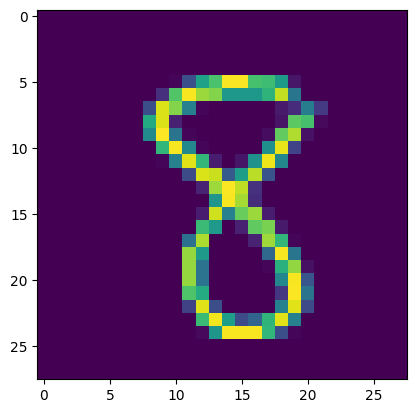


Emelement of index 144 in the test dataset


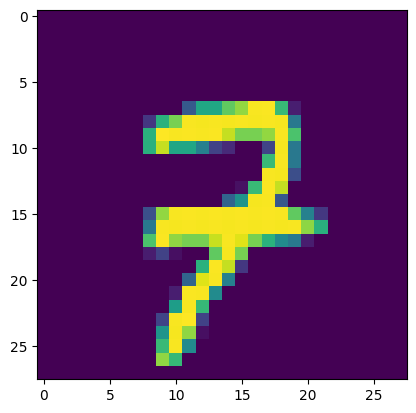

In [3]:
# Some informations on the dataset
print('Training dataset info:\n')
print(train_data,'\nTarget: ',train_data.targets,'\n\n')

print('Test dataset info:\n')
print(test_data,'\nTarget: ',test_data.targets,'\n\n')

index = 144

print()
print('Emelement of index',index,'in the train dataset')
plt.imshow(train_data.data[index])
plt.show()

print()
print('Emelement of index',index,'in the test dataset')
plt.imshow(test_data.data[index])
plt.show()

In [4]:
# Put the datasets into batches

loaders = {

    'train': DataLoader(train_data, 
                        batch_size = 32,
                        shuffle = True,
                        num_workers = 1),

    'test': DataLoader(test_data, 
                        batch_size = 32,
                        shuffle = True,
                        num_workers = 1)
    
}



## Model Architecture

### Convolutional Layers

- Defined by the number of kernels, $O_{ch}$ and the size of the kernel, $K_{size}$
- Each kernel corresponds to a locale feature and introduces a number of parameters $K_{size} \cdot K_{size} \cdot I_{ch} + 1$. The first term represents the weights, while the second represents the bias. 
- A kernel is a matrix of dimension $ [I_{ch},K_{size}, K_{size}]$ plus a bias value. Their elements are initialized randomly and set to zero, respectively. They are applied to the input through a dot product, iterated along all their elements.
- Kernel looks at local regions and not at the full input all at once. This is why convolutional layers are used to determine local features.
- Capture local patterns that are meaningful for images 

### Fully Connected Layers

- Define a number of neurons. All the features in input (which can also be seen as neurons) are connected to all the neurons introduced by the layer. 
- Represented by a single giant weight matrix
- Combine all the features for classifications
- The last layer combines all the features to make the final prediction.

### Dropout
In our case is 2D, and so zeros an entire kernel channel and not single kernel weights. Encourage the network not to rely on any single feature map, improving generalization and avoiding $\textit{Overfitting}$. 

### Overfitting 
$\textit{Overfitting}$ happens when a model learns the training data too well — including its noise, random variations, and irrelevant details — instead of learning the general patterns that apply to new, unseen data.

In [5]:
# Define the CNN model architecture

class CNN(nn.Module):

    # Defines what layers the model has
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1,10,kernel_size = 5)
        self.conv2 = nn.Conv2d(10,20,kernel_size = 5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320,50)
        self.fc2 = nn.Linear(50,10)

    # Defines how data flows through the NN's layers.
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x),2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)),2))
        x = x.view(-1,320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x,training = self.training)
        x = self.fc2(x)

        return F.softmax(x)

- The `forward()` function tells PyTorch how data flows through the layers you defined in `__init__`. Each line transforms the input tensor x (an image) through layers and activations until it becomes a probability distribution over digits 0–9.
- `F.max_pool2d`: downsamples the feature map by taking the maximum value in each small region. This reduces the size of the data while keeping the most important features.
- `F.relu`: applies the ReLU activation function, which sets negative values to 0 and keeps positive values. This introduces non-linearity, allowing the network to learn complex patterns.
- `F.softmax(x)`: converts to probabilities the 10 outputs coming from the last layer, associated to the digits 0-9.

## Training

In [6]:
# To improve the training speed, use the GPU instead of the CPU

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN().to(device)

print('Running on:', device)

Running on: cpu


In [7]:
# Training Process

optimizer = optim.Adam(model.parameters(), lr = 0.001)

loss_fn = nn.CrossEntropyLoss()

def train(epoch):
    model.train()                 # Puts the model in training mode
    for batch_idx, (data,target) in enumerate(loaders['train']):
        data,target = data.to(device),target.to(device)
        optimizer.zero_grad()     # Clears old gradients (from the previous batch) so they don’t accumulate
        output = model(data)      # Sends the batch through the CNN and produces predictions for each image
        loss = loss_fn(output,target)
        loss.backward()           # Calculates the gradients and saves them inside the CNN
        optimizer.step()          # Adjusts each weight using the computed gradients
        if batch_idx % 300 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(loaders["train"].dataset)} ({100. *batch_idx / len(loaders["train"]):.0f}%)]\t{loss.item():.6f}')

- `Adam` is a smart optimization algorithm that adapts the learning rate for each parameter. Gradually reduce the model’s prediction errors by updating weights after each batch. 
- `Measures` how far off the model’s predictions are from the correct labels. Provide a numerical value (“loss”) that gets smaller as the model improves.


In [8]:
# Test Function

def test():
    model.eval() # Set the model into evaluation mode

    test_loss = 0
    correct = 0 

    with torch.no_grad():
        for data, target in loaders['test']:
            data, target = data.to(device), target.to(device)
            output  = model(data)
            test_loss  += loss_fn(output, target).item()
            pred = output.argmax(dim = 1,keepdim = True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss/= len(loaders['test'].dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy {correct}/{len(loaders["test"].dataset)} ({100. *correct /len(loaders["test"].dataset):.0f}%\n)')

- `torch.no_grad()` tells PyTorch not to track gradients — it just runs the model forward to get predictions, saving memory and time since no learning (backpropagation) will happen.

In [9]:
# Training

for epoch in range(1,11):
    train(epoch)
    test()

C:\Users\nino\AppData\Local\Temp\ipykernel_27664\2094222712.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Train Epoch: 1 [0/60000 (0%)]	2.303658
Train Epoch: 1 [9600/60000 (16%)]	2.099509
Train Epoch: 1 [19200/60000 (32%)]	1.895079
Train Epoch: 1 [28800/60000 (48%)]	1.974007
Train Epoch: 1 [38400/60000 (64%)]	1.868297
Train Epoch: 1 [48000/60000 (80%)]	1.904961
Train Epoch: 1 [57600/60000 (96%)]	1.598193

Test set: Average loss: 0.0479, Accuracy 9320/10000 (93%
)
Train Epoch: 2 [0/60000 (0%)]	1.702996
Train Epoch: 2 [9600/60000 (16%)]	1.709211
Train Epoch: 2 [19200/60000 (32%)]	1.749564
Train Epoch: 2 [28800/60000 (48%)]	1.788853
Train Epoch: 2 [38400/60000 (64%)]	1.718649
Train Epoch: 2 [48000/60000 (80%)]	1.693166
Train Epoch: 2 [57600/60000 (96%)]	1.821641

Test set: Average loss: 0.0471, Accuracy 9552/10000 (96%
)
Train Epoch: 3 [0/60000 (0%)]	1.781163
Train Epoch: 3 [9600/60000 (16%)]	1.696351
Train Epoch: 3 [19200/60000 (32%)]	1.706886
Train Epoch: 3 [28800/60000 (48%)]	1.628570
Train Epoch: 3 [38400/60000 (64%)]	1.618037
Train Epoch: 3 [48000/60000 (80%)]	1.672143
Train Epoch: 3 [57

## Testing the Model

Prediction: 6


C:\Users\nino\AppData\Local\Temp\ipykernel_27664\2094222712.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


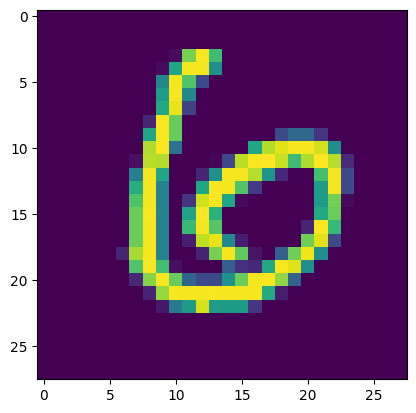

In [10]:
model.eval()

data,target = test_data[11]

data = data.unsqueeze(0).to(device)

output = model(data)

prediction = output.argmax(dim = 1, keepdim = True).item()
print(f'Prediction: {prediction}')

image = data.squeeze(0).squeeze(0).cpu().numpy()

plt.imshow(image)


## Examples with real handwritten digits

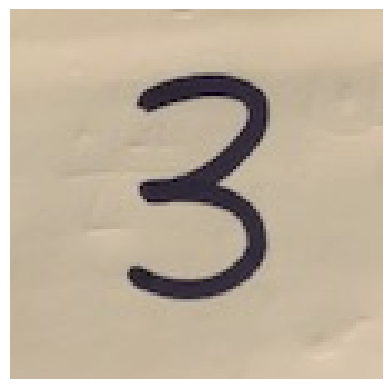

Image size (width, height): (112, 111)
Image mode (color type): RGB
Prediction: 3


C:\Users\nino\AppData\Local\Temp\ipykernel_27664\3314105775.py:25: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  theshold =  0.5*np.max(np.array(img_tensor[0,0,:,:]))
C:\Users\nino\AppData\Local\Temp\ipykernel_27664\2094222712.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


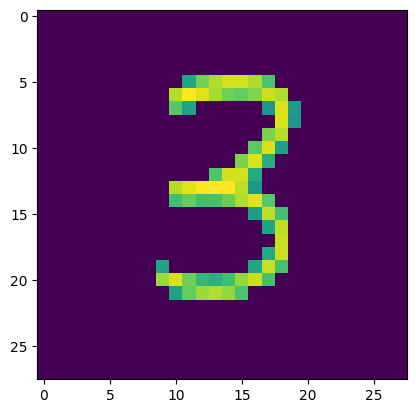

In [16]:
# Download the image
filepath = "your//path"
img = Image.open(filepath)                  
plt.imshow(img)                            
plt.axis('off')                              
plt.show()
print("Image size (width, height):", img.size)
print("Image mode (color type):", img.mode)

# Convert into a proper tensor format 
img = img.convert('L')
img = ImageOps.invert(img) 

transform = transforms.Compose([
    transforms.Grayscale(),      # 1 channel
    transforms.Resize((28, 28)), # same size as MNIST
    transforms.ToTensor(),       # converts to [0,1]
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST normalization
])
img_tensor = transform(img)
img_tensor = img_tensor.unsqueeze(0).to(device)

# Adapt the image to make the CNN's life easier

theshold =  0.5*np.max(np.array(img_tensor[0,0,:,:]))
for i in range(img_tensor.shape[2]):
    for j in range(img_tensor.shape[3]):
        if img_tensor[0,0,i,j]<theshold:
            img_tensor[0,0,i,j]=0
    
plt.imshow(img_tensor[0,0,:,:])

# Send the image to the model for the prediction 
output = model(img_tensor)
prediction = output.argmax(dim = 1, keepdim = True).item()
print(f'Prediction: {prediction}')



